In [25]:
import os

import cv2
import numpy as np
import imutils
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, accuracy_score
from skimage.feature import hog
from skimage import data, exposure
from xgboost import XGBClassifier
import keras
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import progressbar

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

** 讀取資料 **

In [3]:
TRAIN_ROOT = 'train'
TEST_ROOT = 'testset'

In [4]:
def get_images_and_labels(root):
    images, labels = [], []
    df = []
    for path, dic, files in os.walk(root):
        for file in files:
            if file.endswith('.jpg'):
                df.append([os.path.join(path, file), path.split('\\')[1]])
                
    return pd.DataFrame(df, columns=['img_path', 'label'])

In [5]:
def get_test_set(root):
    paths = []
    for path, dic, files in os.walk(root):
        for file in files:
            if file.endswith('.jpg'):
                paths.append([os.path.join(path, file)])                
    return pd.DataFrame(paths, columns=['img_path'])

In [6]:
img_df = get_images_and_labels(TRAIN_ROOT)
NUM_CLASSES = len(list(set(img_df.label.values)))
test_df = get_test_set(TEST_ROOT)

** 將類別以數字表示 **

In [18]:
class_mapping = {
'CALsuburb': 9,
'PARoffice': 7,
'bedroom': 12,
'coast': 10,
'forest': 4,
'highway': 14,
'industrial': 2,
'insidecity': 3,
'kitchen': 0,
'livingroom': 5,
'mountain': 8,
'opencountry': 6,
'store': 11,
'street': 1,
'tallbuilding': 13}
img_df['int_label'] = img_df['label'].map(class_mapping)

** hog **
<br>histogram of gradient

C:\Users\User\AppData\Local\conda\conda\envs\ds\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


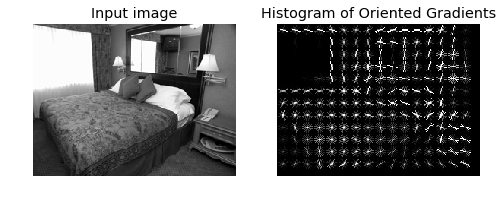

In [7]:
image = cv2.cvtColor(cv2.imread(img_df.iloc[0].img_path), cv2.COLOR_BGR2GRAY)


fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

** hog helper function **

In [13]:
def get_hog_features(image):
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(16, 16),
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
    return fd

** 像素強度分度 **

In [8]:
gray = cv2.cvtColor(cv2.imread(img_df.iloc[0].img_path), cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

(0, 256)

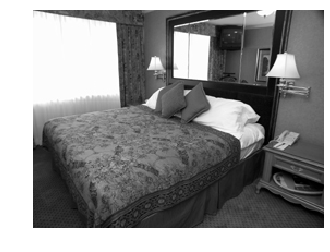

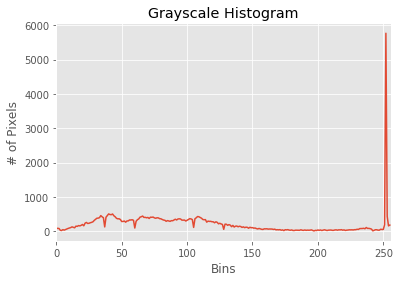

In [9]:
plt.figure()
plt.axis("off")
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB))

plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

In [11]:
def make_square_by_padding(im, desired_size=256):
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    return new_im

In [14]:
images = [make_square_by_padding(cv2.imread(row.img_path)) for _, row in img_df.iterrows()]
gray = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]
hogs = [get_hog_features(gray_scale_image) for gray_scale_image in gray]
hogs = np.array(hogs)
color_hist = np.array([cv2.calcHist([_gray], [0], None, [256], [0, 256]) for _gray in gray])

features = np.hstack((hogs, color_hist.reshape(2985, 256, )))

C:\Users\User\AppData\Local\conda\conda\envs\ds\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


### Feature Testing

** 使用分層抽樣以避免類別的抽樣偏頗 **

In [19]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(hogs, img_df.int_label):
    train_x = np.array([features[i] for i in train_index])
    train_y = np.uint8([img_df.iloc[i].int_label for i in train_index])
    valid_x = np.array([features[i] for i in test_index])
    valid_y = np.uint8([img_df.iloc[i].int_label for i in test_index])

** xgb model for classification **

In [22]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=-1)
xgb.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=-1, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [26]:
y_pred = xgb.predict(valid_x)
print("Accuracy: "+str(accuracy_score(valid_y, y_pred)))
print('\n')
print(classification_report(valid_y, y_pred))

Accuracy: 0.7386934673366834


              precision    recall  f1-score   support

           0       0.60      0.41      0.49        22
           1       0.94      0.82      0.87        38
           2       0.73      0.64      0.68        42
           3       0.70      0.74      0.72        42
           4       0.88      0.93      0.91        46
           5       0.65      0.63      0.64        38
           6       0.61      0.69      0.65        62
           7       0.78      0.78      0.78        23
           8       0.71      0.73      0.72        55
           9       0.88      1.00      0.93        28
          10       0.78      0.75      0.76        52
          11       0.61      0.81      0.70        43
          12       0.47      0.30      0.37        23
          13       0.75      0.76      0.76        51
          14       1.00      0.84      0.92        32

   micro avg       0.74      0.74      0.74       597
   macro avg       0.74      0.72      0.73      

## 深度學習模型作為特徵擷取器
使用先前預訓練的resnet101作為特徵擷取器(去掉最後的dense layer)，與hog以及histogram做特徵結合，用以測試特徵的效度

** 讀取預訓練的模型 **

In [110]:
resnet_101 = keras.models.load_model('resnet_101.h5')

In [123]:
train_set = [make_square_by_padding(cv2.imread(row.img_path)) for _, row in img_df.iterrows()]
train_set = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in train_set]
train_set = np.array(train_set).astype('float')
train_set_mean = np.mean(train_set, axis=0)
train_set -= train_set_mean
train_set = train_set.reshape((len(train_set), 256, 256, 1))
train_set.shape

(2985, 256, 256, 1)

** 獲得最後第二層網絡的名稱 **

In [127]:
resnet_101.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 128, 128, 64) 3200        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_101 (BatchN (None, 128, 128, 64) 256         conv2d_105[0][0]                 
__________________________________________________________________________________________________
activation_101 (Activation)     (None, 128, 128, 64) 0           batch_normalization_101[0][0]    
__________________________________________________________________________________________________
max_poolin

In [117]:
layer_name = 'average_pooling2d_2'
intermediate_layer_model = Model(inputs=resnet_101.input,
                                 outputs=resnet_101.get_layer(layer_name).output)
cnn_feature_extraction = intermediate_layer_model.predict(train_set).reshape((2985, 2048)

## CNN extraction / Hog / histogram

In [131]:
concat_ft = np.hstack((cnn_feature_extraction, features))

In [132]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(hogs, img_df.int_label):
    train_x = np.array([concat_ft[i] for i in train_index])
    train_y = np.uint8([img_df.iloc[i].int_label for i in train_index])
    valid_x = np.array([concat_ft[i] for i in test_index])
    valid_y = np.uint8([img_df.iloc[i].int_label for i in test_index])

In [145]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [148]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
xgb.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=1, nthread=1, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [149]:
y_pred = xgb.predict(valid_x)

print("Accuracy: "+str(accuracy_score(valid_y, y_pred)))
print('\n')
print(classification_report(valid_y, y_pred))

Accuracy: 0.7872696817420436


              precision    recall  f1-score   support

           0       0.68      0.68      0.68        22
           1       0.89      0.87      0.88        38
           2       0.72      0.67      0.69        42
           3       0.77      0.98      0.86        42
           4       0.88      0.91      0.89        46
           5       0.48      0.61      0.53        38
           6       0.75      0.79      0.77        62
           7       0.85      0.74      0.79        23
           8       0.89      0.87      0.88        55
           9       1.00      0.86      0.92        28
          10       0.81      0.81      0.81        52
          11       0.75      0.70      0.72        43
          12       0.40      0.43      0.42        23
          13       0.95      0.76      0.85        51
          14       1.00      0.91      0.95        32

   micro avg       0.79      0.79      0.79       597
   macro avg       0.79      0.77      0.78      

### Submission
因為不明原因不能夠上傳預測結果，因此還沒有證實新版的特徵表現如何...